In [107]:
import matplotlib.pyplot as plt 
import torchvision
import sys
import torch.nn as nn

sys.path.append("..")
import transformations as custom_transforms
import datasets as datasets


%load_ext autoreload
%autoreload 2
%matplotlib inline

# do not use transorms.ToTensor(),already implemented implicitly. 

L = datasets.SegmentationDatasetLabeled(
    dir_images="./my_dataset/images/",
    dir_masks="./my_dataset/masks/",
    
)

gaussian_blur = custom_transforms.RandomGaussianBlur(3)
random_affine = custom_transforms.RandomAffine(
    degrees=50,
    translate=(0.05, 0.05),
    scale=(0.95, 1.05)
)
random_prespective = custom_transforms.RandomPerspective(p=1,distortion_scale=0.5)
gaussian_noise = custom_transforms.GaussianNoiseChannelwise(sigma=[0,0,0.1])

transforamtions = [gaussian_blur,random_prespective,gaussian_noise]
t_choice = torchvision.transforms.RandomChoice(transforamtions)
t_seq = custom_transforms.Compose(transforamtions)
#custom_transforms.RandomApply(nn.ModuleList(transforamtions))

t = t_seq
for i in range(len(L)):
    img_, mask_ = L[i]
    mask_ = mask_[:,:,:]
    img_, mask_ = t(img_,mask_)
    
    print(img_.size())
    print(mask_.size())

    img__ = img_.permute(1, 2, 0)
    mask__ = mask_.permute(1, 2, 0)
    plt.imshow(img__)
    plt.figure()
    plt.imshow(mask__)
    plt.show()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RuntimeError: einsum(): the number of subscripts in the equation (4) does not match the number of dimensions (3) for operand 1 and no ellipsis was given

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
torch.Size([3, 3, 321, 481])
torch.Size([12, 3, 321, 481])


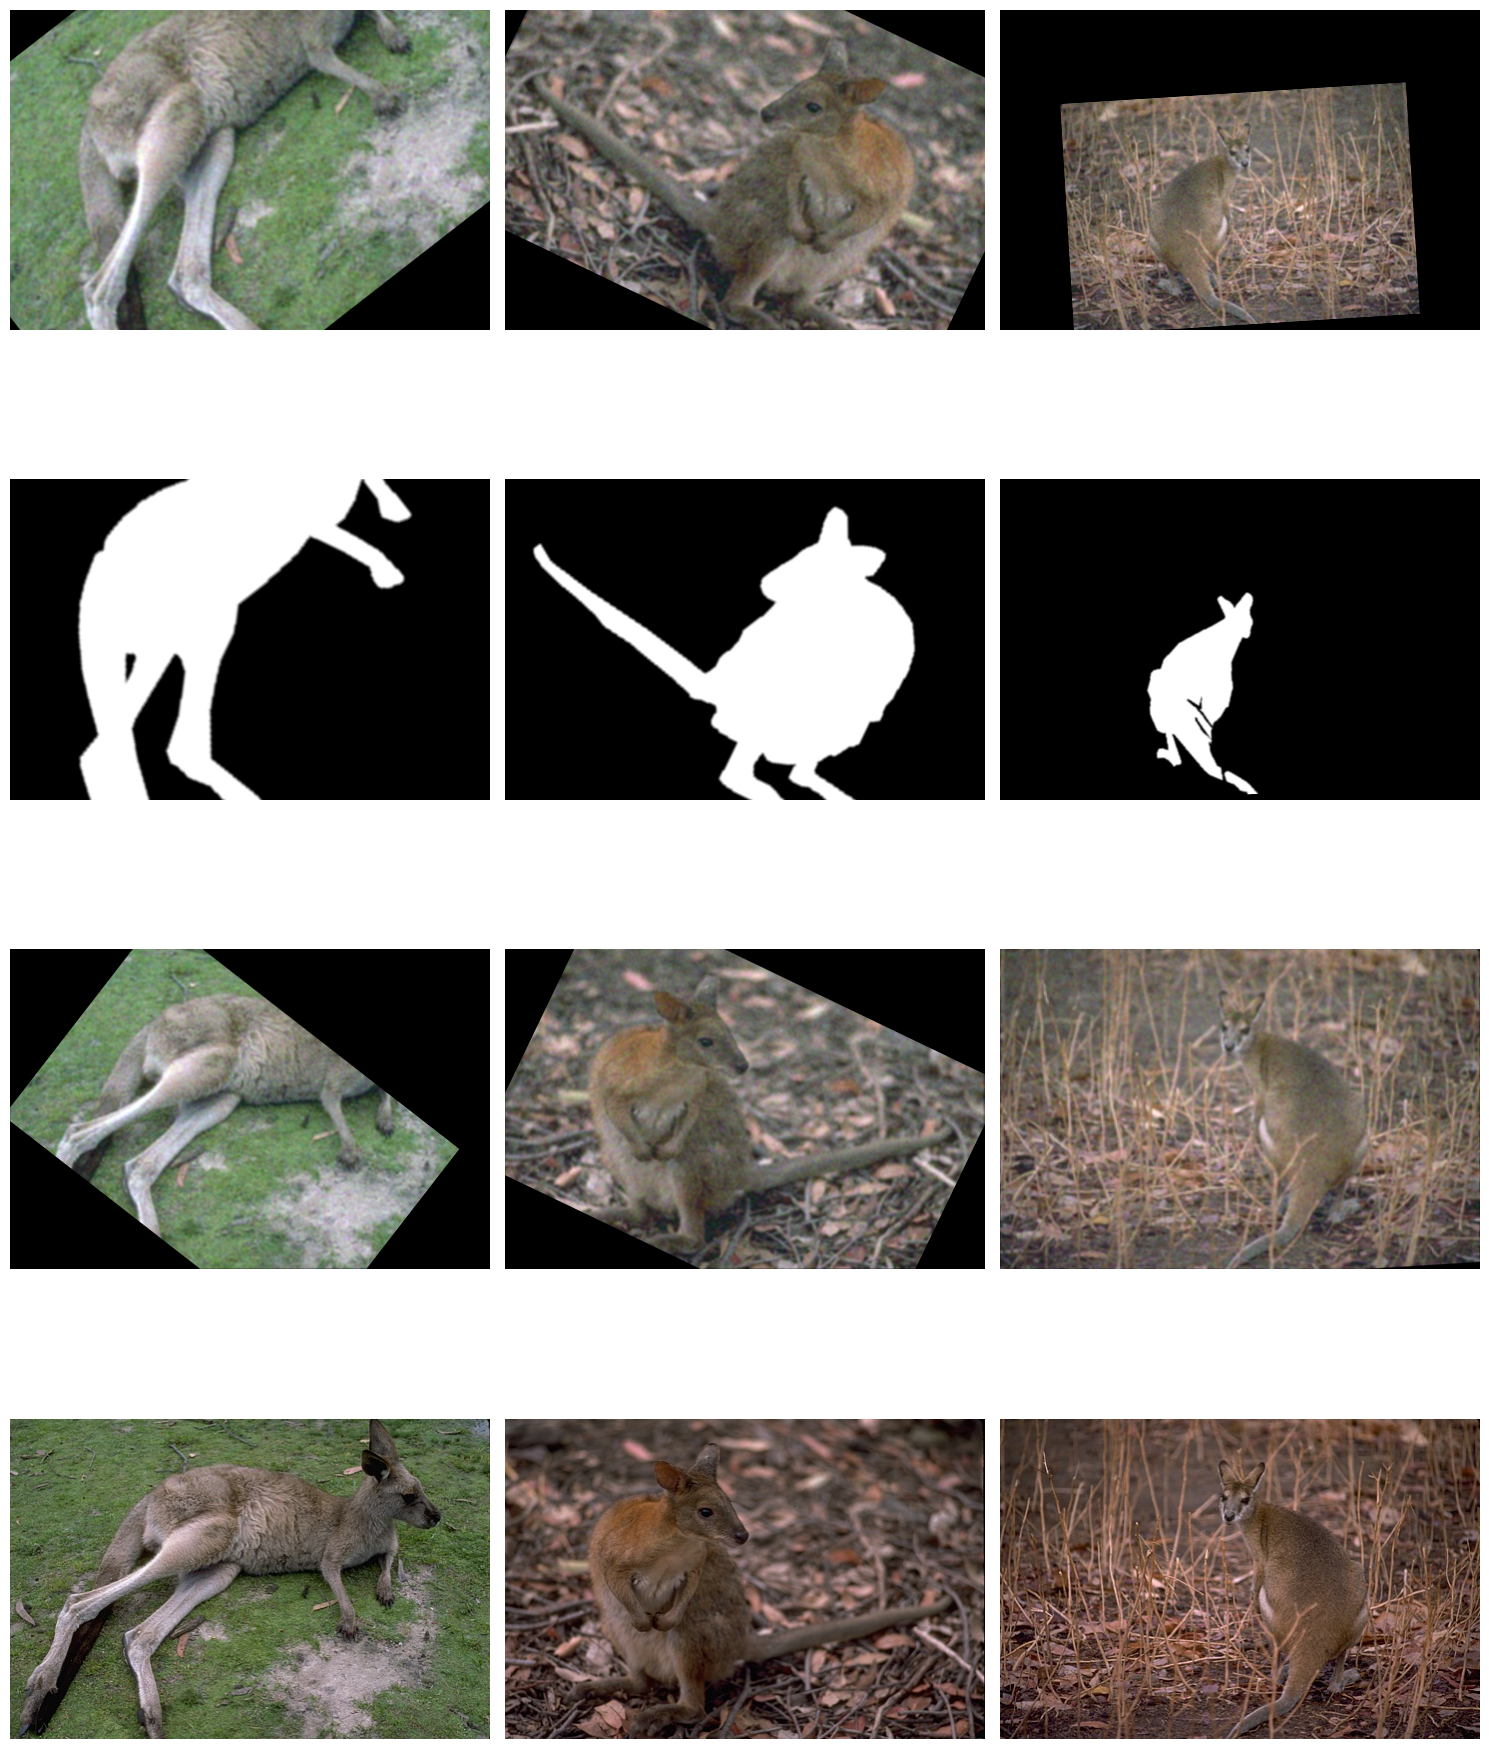

ValueError: too many values to unpack (expected 1)

In [116]:
import kornia as K
import transformations as custom_transforms
import torch

%load_ext autoreload
%autoreload 2
%matplotlib inline

from utils import plot_batch

k1 = custom_transforms.GaussianNoiseChannelwise((0.15, 0.25, 0.25))
k2 = K.augmentation.RandomGaussianBlur((3,3),sigma=(5.,1.),p=0.75)
k3 = K.augmentation.RandomHorizontalFlip(p=0.75)
k4 = K.augmentation.RandomAffine([-45., 45.], [0., 0.15], [0.5, 1.5], [0., 0.15])

img_trans = nn.ModuleList([k1,k2,k3,k4])
mask_trans = nn.ModuleList([k2,k3,k4]) 
invert_trans  = nn.ModuleList([k3,k4])

segmentation_transform = custom_transforms.MyAugmentation(img_trans,mask_trans,invert_trans)

imgs = []
masks = []
for i in range(len(L)):
    img_, mask_ = L[i]
    imgs.append(img_.unsqueeze(0))
    masks.append(mask_.unsqueeze(0))

imgs = torch.cat(imgs,dim=0)
masks = torch.cat(masks,dim=0)
print(imgs.shape)
orig_imgs = imgs
imgs,masks = segmentation_transform(imgs,masks)
retrived_imgs = segmentation_transform.inverse_last_transformation(imgs)
img_out = torch.cat([imgs, masks,retrived_imgs,orig_imgs], dim=0)
img_out = img_out.clip(0,1)
print(img_out.shape)
plot_batch(img_out,num_rows=4)

only_img,_  = segmentation_transform(imgs)
plot_batch(only_img)